In [1]:
%load_ext autoreload
%autoreload 2

from spyglass.decoding.v1.clusterless import UnitWaveformFeaturesGroup, UnitWaveformFeatures
import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"
import jax
os.chdir("..")

[2025-11-14 12:46:53,324][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-11-14 12:46:53,475][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load Data

### Waveforms

In [2]:
key = {
    "nwb_file_name": "Wallie20220912_.nwb",
    "waveform_features_group_name": "10_lineartrack",
}


# waveform_keys = (UnitWaveformFeaturesGroup().UnitFeatures & key).fetch("KEY")
# times_list, marks_list = (UnitWaveformFeatures & waveform_keys).fetch_data()
# mark_times = []
# marks = []

# n_shanks = len(times_list)

# for shank, (t, m) in enumerate(zip(times_list, marks_list)):
#     mark_times.extend(t)
#     # mark = np.zeros((len(t),m.shape[1],n_shanks))
#     # mark[:, :, shank] = m
#     # marks.extend(mark)
#     mark = np.zeros((len(t), 4 + 1))
#     mark[:, : m.shape[1]] = m
#     mark[:, -1] = shank
#     marks.extend(mark)


# marks = np.array(marks)
# mark_times = np.array(mark_times)
# print(marks.shape, mark_times.shape)

# ind = np.argsort(mark_times)
# mark_times = mark_times[ind]
# marks = marks[ind]

# # standardize marks
# marks[:, :-1] = marks[:, :-1] - np.mean(marks[:, :-1], axis=1)[:, None]
# # standardize times
# first_mark_time = mark_times[0]
# mark_times = mark_times - first_mark_time
# mark_times = mark_times * 1000
# marks[:, :-1] = marks[:, :-1] / 1000  # np.max(np.abs(marks))

### Position data

In [3]:
# load position data
from spyglass.common import PositionIntervalMap
from spyglass.decoding.v1.core import PositionGroup
from spyglass.position.position_merge import PositionOutput
from spyglass.linearization.v1 import LinearizedPositionV1
from scipy.ndimage import gaussian_filter1d

epoch_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": key["waveform_features_group_name"],
}
pos_interval = (PositionIntervalMap() & epoch_key).fetch1("position_interval_name")
pos_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": pos_interval,
    "trodes_pos_params_name": "single_led_upsampled",
}
pos_merge_id = (PositionOutput.TrodesPosV1() & pos_key).fetch("merge_id")
pos_merge_key = {"pos_merge_id": pos_merge_id[0]}


pos_df = (LinearizedPositionV1() & pos_merge_key).fetch1_dataframe()
pos_times = pos_df.index.values  # - first_mark_time
pos = pos_df.linear_position.values
vel = np.diff(pos_df.linear_position.values)
vel = np.concatenate([vel, [vel[-1]]])
vel = gaussian_filter1d(vel, 11, axis=0, mode="nearest")

# pos_ind = np.digitize(mark_times / 1000, pos_times - first_mark_time) - 1
# mark_pos = pos[pos_ind]
# mark_vel = vel[pos_ind]

# Define position-based intervals
all_running = (np.abs(vel * 500) > 10).astype(int)
right_running = ((vel * 500) > 10).astype(int)
left_running = ((vel * 500) < -10).astype(int)

st = np.where(np.diff(all_running) == 1)[0]
en = np.where(np.diff(all_running) == -1)[0]
if en[0] < st[0]:
    en = en[1:]
all_running_intervals = np.array(
    [[pos_df.index[s], pos_df.index[e]] for s, e in zip(st, en)]
)
st = np.where(np.diff(left_running) == 1)[0]
en = np.where(np.diff(left_running) == -1)[0]
if en[0] < st[0]:
    en = en[1:]
left_running_intervals = np.array(
    [[pos_df.index[s], pos_df.index[e]] for s, e in zip(st, en)]
)

st = np.where(np.diff(right_running) == 1)[0]
en = np.where(np.diff(right_running) == -1)[0]
if en[0] < st[0]:
    en = en[1:]
right_running_intervals = np.array(
    [[pos_df.index[s], pos_df.index[e]] for s, e in zip(st, en)]
)

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


### LFP

In [ ]:
from spyglass.lfp.analysis.v1 import LFPBandV1
from spyglass.lfp import LFPOutput

ref_ind = 12  # hardcoded for dataset Wallie20220912_.nwb
lfp_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    "target_interval_list_name": pos_key["interval_list_name"],
}

exclude = (
    (LFPOutput.LFPV1() & {"lfp_electrode_group_name": "tetrode_samples"})
    .proj(lfp_merge_id="merge_id")
    .fetch("lfp_merge_id", as_dict=True)
)


# Theta band
theta_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    "target_interval_list_name": pos_key["interval_list_name"],
    "filter_name": "Theta 5-11 Hz",
    # "filter_name": "Fast Gamma 65-100 Hz",
    # "filter_name": "Slow Gamma 25-55 Hz",
}
query = (LFPBandV1() & theta_key) - exclude

theta_band_obj = query.fetch_nwb()[0]["lfp_band"]
phase_df = query.compute_signal_phase([ref_ind])
power_df = query.compute_signal_power([ref_ind])
phase_df["phase"] = phase_df.values
phase_df["power"] = power_df.values

# Fast Gamma band
fast_gamma_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    "target_interval_list_name": pos_key["interval_list_name"],
    "filter_name": "Fast Gamma 65-100 Hz",
    # "filter_name": "Slow Gamma 25-55 Hz",
}
query = (LFPBandV1() & fast_gamma_key) - exclude
band_obj = query.fetch_nwb()[0]["lfp_band"]
fg_phase_df = query.compute_signal_phase([ref_ind])
fg_power_df = query.compute_signal_power([ref_ind])
fg_phase_df["phase"] = fg_phase_df.values
fg_phase_df["power"] = fg_power_df.values

# Slow Gamma band
slow_gamma_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    "target_interval_list_name": pos_key["interval_list_name"],
    "filter_name": "Slow Gamma 25-55 Hz",
}
query = (LFPBandV1() & slow_gamma_key) - exclude
band_obj = query.fetch_nwb()[0]["lfp_band"]
sg_phase_df = query.compute_signal_phase([ref_ind])
sg_power_df = query.compute_signal_power([ref_ind])
sg_phase_df["phase"] = sg_phase_df.values
sg_phase_df["power"] = sg_power_df.values

# Ripple band
ripple_band_key = {
    "nwb_file_name": pos_key["nwb_file_name"],
    # "target_interval_list_name": pos_key["interval_list_name"],
    "filter_name": "Ripple 150-250 Hz",
}

query = (
    LFPBandV1
    & ripple_band_key
    & f"target_interval_list_name LIKE '%{pos_key['interval_list_name']}%'"
)
ripple_band_obj = query.fetch_nwb()[0]["lfp_band"]

In [191]:
from spyglass.lfp.v1 import LFPV1

lfp_query = (LFPV1 & lfp_key) & dict(lfp_electrode_group_name="tetrode_sample_Wallie")
lfp_df = lfp_query.fetch1_dataframe()

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [193]:
lfp_df = lfp_df[ref_ind]

### Sorted Spikes Data

In [14]:
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

spikes_key = {
    "nwb_file_name": key["nwb_file_name"],
    "sorted_spikes_group_name": key["waveform_features_group_name"],
}
SortedSpikesGroup() & spikes_key
spikes_list, unit_ids = (SortedSpikesGroup() & spikes_key).fetch_spike_data(
    spikes_key, return_unit_ids=True
)

KeyboardInterrupt: 

### Ripple times

In [202]:
from spyglass.ripple.v1 import RippleTimesV1, RippleLFPSelection

ripple_df = (
    RippleTimesV1()
    & key
    & f"target_interval_list_name LIKE '%{pos_key['interval_list_name']}%'"
).fetch1_dataframe()

In [ ]:
ripple_query = (
    RippleTimesV1()
    & key
    & f"target_interval_list_name LIKE '%{pos_key['interval_list_name']}%'"
)

RippleLFPSelection

*lfp_merge_id  *filter_name   *filter_sampli *nwb_file_name *target_interv *lfp_band_samp *group_name   
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
4acdad2e-ae15- Ripple 150-250 1000           Wallie20220912 Wallie20220912 1000           CA1           
 (Total: 1)

### DIO Behavior times

In [7]:
from spyglass.common import DIOEvents

event_types = ["poke", "reward"]
behavior_evenets = {}
for dio in event_types:
    dio_query = DIOEvents() & key & f"dio_event_name LIKE '%{dio}%'"
    marks = []
    for nwb in dio_query.fetch_nwb():
        obj = nwb["dio"]
        t = obj.timestamps[:]
        data = obj.data[:]
        marks.extend(t[data == 1])
    marks = np.array(marks)
    behavior_evenets[dio] = marks

[2025-11-14 12:56:15,337][WARNING]: Skipped checksum for file with hash: bbc80993-55d4-5fc6-0ca9-d62eecdb0f15, and path: /stelmo/nwb/raw/Wallie20220912_.nwb
[2025-11-14 12:56:15,350][WARNING]: Skipped checksum for file with hash: bbc80993-55d4-5fc6-0ca9-d62eecdb0f15, and path: /stelmo/nwb/raw/Wallie20220912_.nwb
[2025-11-14 12:56:15,366][WARNING]: Skipped checksum for file with hash: bbc80993-55d4-5fc6-0ca9-d62eecdb0f15, and path: /stelmo/nwb/raw/Wallie20220912_.nwb
[2025-11-14 12:56:15,381][WARNING]: Skipped checksum for file with hash: bbc80993-55d4-5fc6-0ca9-d62eecdb0f15, and path: /stelmo/nwb/raw/Wallie20220912_.nwb
[2025-11-14 12:56:15,398][WARNING]: Skipped checksum for file with hash: bbc80993-55d4-5fc6-0ca9-d62eecdb0f15, and path: /stelmo/nwb/raw/Wallie20220912_.nwb
[2025-11-14 12:56:33,880][WARNING]: Skipped checksum for file with hash: bbc80993-55d4-5fc6-0ca9-d62eecdb0f15, and path: /stelmo/nwb/raw/Wallie20220912_.nwb
[2025-11-14 12:56:33,899][WARNING]: Skipped checksum for f

# Load embedding model and results

In [ ]:
import os

# if not "src" in os.listdir():
#     os.chdir("..")
os.chdir("/home/sambray/Documents/c3po/")

from src.c3po.tables.dev_tables import C3POStorage

model_name = "rat_hpc_lineartrack_16d"
model_name = "rat_hpc_lineartrack_c20z32"
model_name = "rat_hpc_lineartrack_c20z20_model2"
# model_name = "rat_hpc_lineartrack_c20z20_model2_trainRuns"
model_name = "rat_hpc_lineartrack_c20z20_model2_trainRuns_onlySmallNegSamples"
model_name = "rat_hpc_lineartrack_c20z20_model3"
# model_name = "rat_hpc_lineartrack_c8z20_model3"

model_key = {"model_name": model_name}
analysis = (C3POStorage & model_key).fetch_analysis_object()

analysis.load_embedding(
    f"/stelmo/sam/c3po_results/{model_key['model_name']}_embedding.npz"
)

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.0003)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()
analysis.fit_context_pca(fit_intervals=all_running_intervals)

# # Just showing how to access the variables
# t = analysis.t
# z = analysis.z
# c = analysis.c
# c_pca = analysis.c_pca
# t_interp = analysis.t_interp
# c_interp = analysis.c_interp
# c_pca_interp = analysis.c_pca_interp
# latent_dim, context_dim = analysis.latent_dim, analysis.context_dim

x shape (1, 5)


# Analyze!

## Example Traces

(0.0, 2.0)

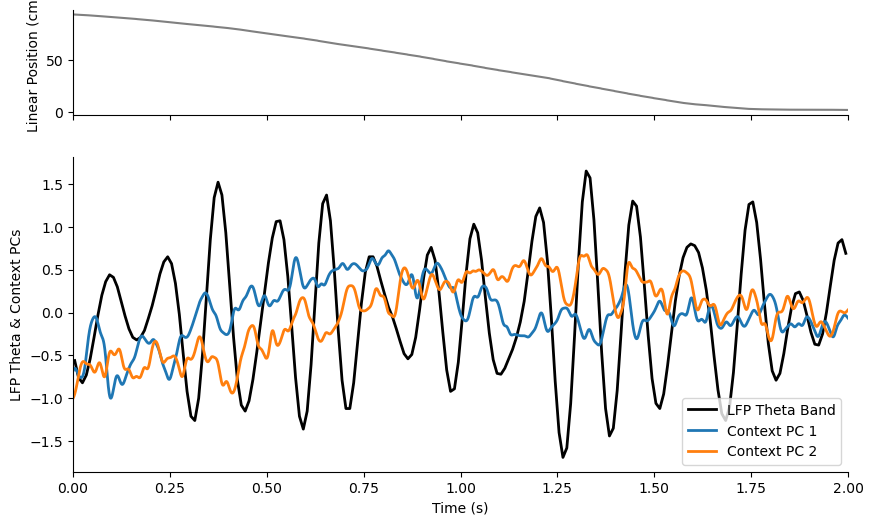

In [ ]:
i = 30
# t_rng = 2,5
# t_rng = 2.5, 3.5

i = 5
t_rng = -1, 2
t_rng = 1.6, 2.6
t_rng = 4, 6

pc_inds = np.array([0, 1])
# t_rng = 3,4

fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    height_ratios=[1, 3],
    figsize=(10, 6),
)

interval = [i_ for i_ in left_running_intervals if i_[1] - i_[0] > 0.5]
interval = interval[i]
st = left_running_intervals[i][0] + t_rng[0]
en = left_running_intervals[i][0] + t_rng[1]

t_theta = theta_band_obj.timestamps
ind_theta = np.logical_and(
    t_theta >= st,
    t_theta <= en,
)
plt.plot(
    t_theta[ind_theta] - st,
    theta_band_obj.data[ind_theta][:, ref_ind] / 100,
    c="k",
    lw=2,
    zorder=-10,
    label="LFP Theta Band",
)

ind_context = np.logical_and(
    analysis.t_interp >= st,
    analysis.t_interp <= en,
)
c_plot = analysis.c_pca_interp[ind_context][:, pc_inds]
if len(c_plot.shape) == 1:
    c_plot = c_plot[:, None]

c_plot = gaussian_filter1d(c_plot, 21, axis=0, mode="nearest")
c_plot = c_plot - np.mean(c_plot, axis=0)
c_plot = c_plot / (np.max(np.abs(c_plot), axis=0))
for j in range(c_plot.shape[1]):
    plt.plot(
        analysis.t_interp[ind_context] - st,
        c_plot[:, j],
        zorder=-1,
        label=f"Context PC {j+1}",
        lw=2,
    )


pos_ind = np.logical_and(
    pos_df.index >= st,
    pos_df.index <= en,
)
ax[0].plot(
    pos_df.index[pos_ind] - st,
    pos_df.linear_position[pos_ind],
    c="gray",
    # s=5,
    zorder=-5,
)
# plt.xlim(4,5)
# plt.xlim(2,3)
# ind_theta = np.logical_and(
#     phase_df.index >= left_running_intervals[i][0], phase_df.index <= left_running_intervals[i][0] +dur,
# )
# plt.plot(phase_df.index[ind_theta], phase_df["electrode 12"].values[ind_theta])

ax[1].legend(loc="lower right")
for a in ax:
    a.spines[["top", "right"]].set_visible(False)

ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("Linear Position (cm)")
ax[1].set_ylabel("LFP Theta & Context PCs")
plt.xlim(0, t_rng[1] - t_rng[0])

## Power Spectrums

In [116]:
f, mid, lo, hi = analysis.power_spectrum(
    intervals=all_running_intervals,
    pca=True,
    window_size=int(2 / np.mean(np.diff(t_interp[:10]))),
    nfft=50000,
)

Text(0.5, 1.0, 'context power spectrums')

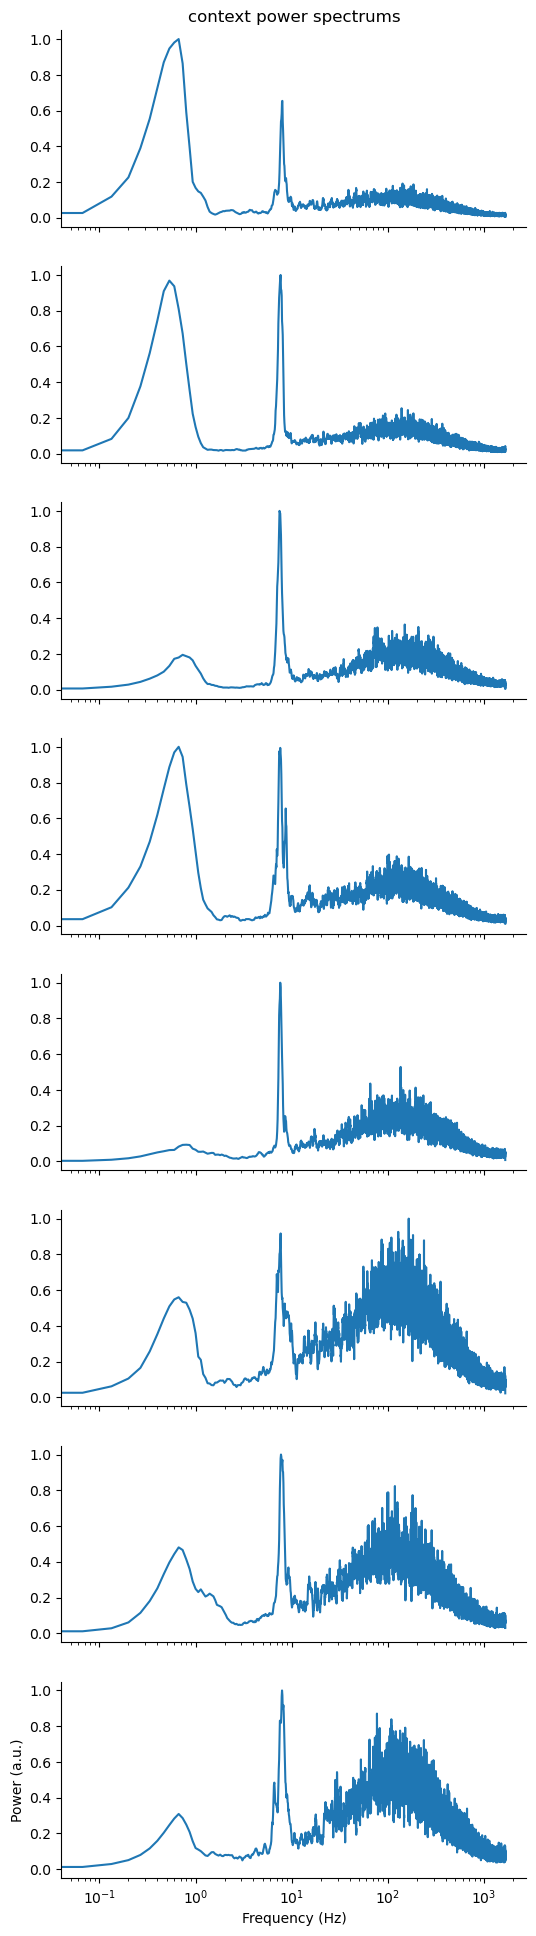

In [117]:
n_plot = 8

norm_mid = mid.T * f[:, None]
norm_mid = norm_mid / np.max(norm_mid, axis=0)
# norm_mid = norm_mid[:,:]


fig, ax = plt.subplots(nrows=n_plot, figsize=(6, 3 * n_plot), sharex=True)
for i, a in enumerate(ax):
    a.plot(f, norm_mid[:, i])
    a.set_xscale("log")
    a.spines[["top", "right"]].set_visible(False)
# plt.plot(f, norm_mid)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
ax[0].set_title("context power spectrums")

Text(0.5, 1.0, 'context power spectrums')

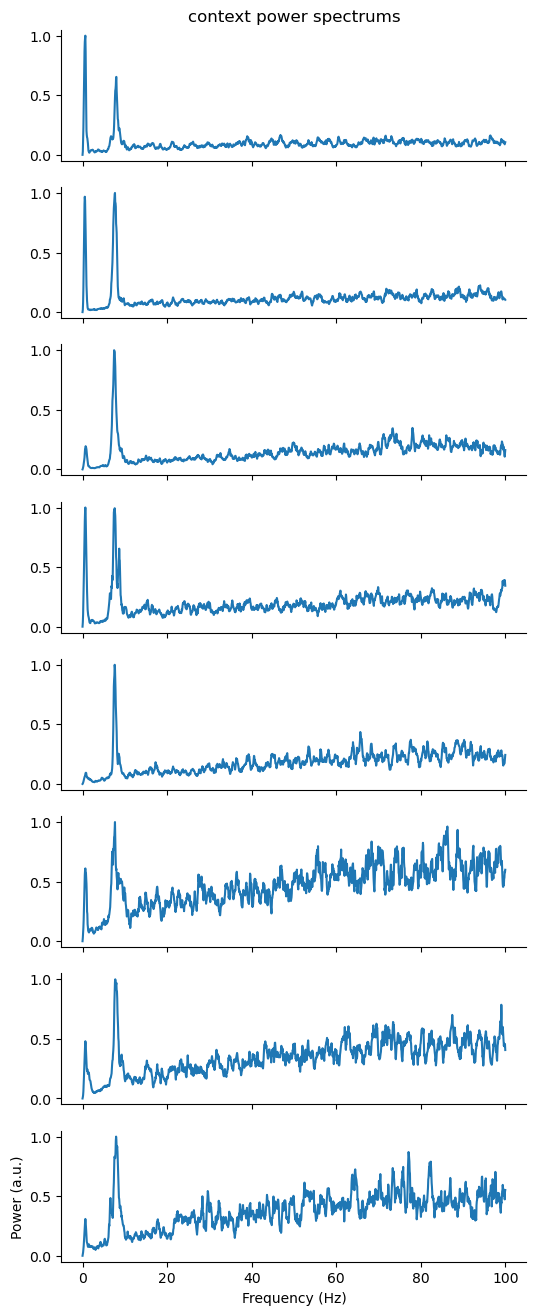

In [119]:
n_plot = 8
f_rng = (0, 100)

ind_plot = np.where((f >= f_rng[0]) & (f <= f_rng[1]))[0]
norm_mid = mid[:, ind_plot].T * f[ind_plot, None]
norm_mid = norm_mid / np.max(norm_mid, axis=0)
# norm_mid = norm_mid[:,:]


fig, ax = plt.subplots(nrows=n_plot, figsize=(6, 2 * n_plot), sharex=True)
for i, a in enumerate(ax):
    a.plot(f[ind_plot], norm_mid[:, i])
    # a.set_xscale("log")
    a.spines[["top", "right"]].set_visible(False)
# plt.plot(f, norm_mid)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
ax[0].set_title("context power spectrums")

## Context value vs. position

In [120]:
pos_bins = np.linspace(10, 110, 50)
pca = True

left_binned_context, bins = analysis.bin_context_by_feature(
    pos_df.linear_position.values,
    pos_df.index,
    pca=pca,
    valid_intervals=left_running_intervals,
    bins=pos_bins,
)

right_binned_context, bins = analysis.bin_context_by_feature(
    pos_df.linear_position.values,
    pos_df.index,
    pca=pca,
    valid_intervals=right_running_intervals,
    bins=pos_bins,
)

mid_list = []
lo_list = []
hi_list = []

for j, binned_context in enumerate([left_binned_context, right_binned_context]):
    mid = np.array([np.nanmedian(b, axis=0) for b in binned_context])
    hi = np.array(
        [
            np.nanpercentile(
                b,
                75,
                axis=0,
            )
            for b in binned_context
        ]
    )
    lo = np.array(
        [
            np.nanpercentile(
                b,
                25,
                axis=0,
            )
            for b in binned_context
        ]
    )
    mid_list.append(mid)
    lo_list.append(lo)
    hi_list.append(hi)

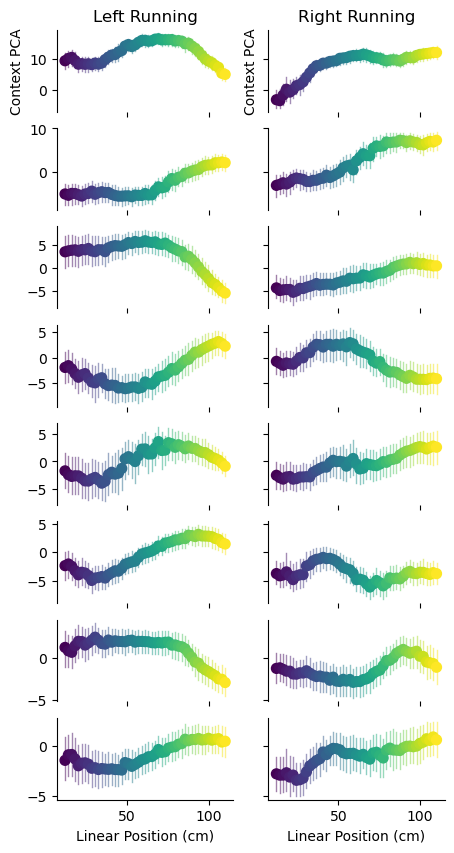

In [121]:
fig, ax_list = plt.subplots(
    nrows=min(context_dim, 8), ncols=2, sharex=True, sharey="row", figsize=(5, 10)
)
for j, name in enumerate(["Left", "Right"]):
    ax = ax_list[:, j]
    mid = mid_list[j]
    lo = lo_list[j]
    hi = hi_list[j]
    c = np.linspace(0, 1, mid.shape[0])
    for i, a in enumerate(ax):
        a.scatter(bins[1:], mid[:, i], s=50, c=c)
        # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5, zorder=-1)
        for k in range(len(bins[1:])):
            a.plot(
                [bins[k + 1], bins[k + 1]],
                [lo[k, i], hi[k, i]],
                alpha=0.5,
                zorder=-1,
                c=plt.cm.viridis(c[k]),
                lw=1,
            )
        a.spines[["top", "right", "bottom"]].set_visible(False)
    ax[-1].spines["bottom"].set_visible(True)

    ax[-1].set_xlabel("Linear Position (cm)")
    ax[0].set_title(f"{name} Running")
    ax[0].set_ylabel("Context PCA")

Text(0, 0.5, 'Context PCA 5')

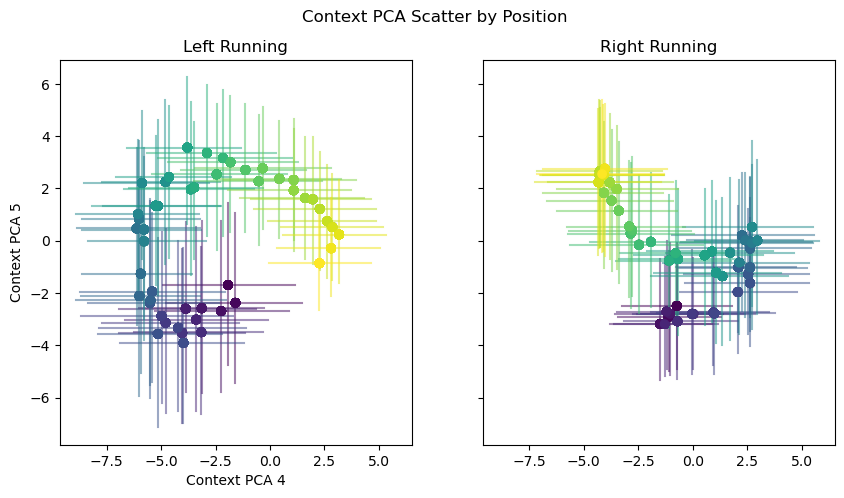

In [122]:
axes = 1, 2
axes = 0, 1
axes = 3, 4
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, sharex=True, sharey=True)


for j, a in enumerate(ax):
    mid = mid_list[j]
    lo = lo_list[j]
    hi = hi_list[j]
    for i, c_i in enumerate(c):
        a.scatter(mid[:, axes[0]], mid[:, axes[1]], c=c, alpha=1)
        a.plot(
            [mid[i, axes[0]], mid[i, axes[0]]],
            [lo[i, axes[1]], hi[i, axes[1]]],
            c=plt.cm.viridis(c_i),
            alpha=0.5,
            zorder=-1,
        )
        a.plot(
            [lo[i, axes[0]], hi[i, axes[0]]],
            [mid[i, axes[1]], mid[i, axes[1]]],
            c=plt.cm.viridis(c_i),
            alpha=0.5,
            zorder=-1,
        )

fig.suptitle("Context PCA Scatter by Position")
ax[0].set_title("Left Running")
ax[1].set_title("Right Running")
ax[0].set_xlabel(f"Context PCA {axes[0]+1}")
ax[0].set_ylabel(f"Context PCA {axes[1]+1}")

## Context value vs LFP Bands

### Theta

Text(0.5, 1.0, 'Theta 5-11 Hz')

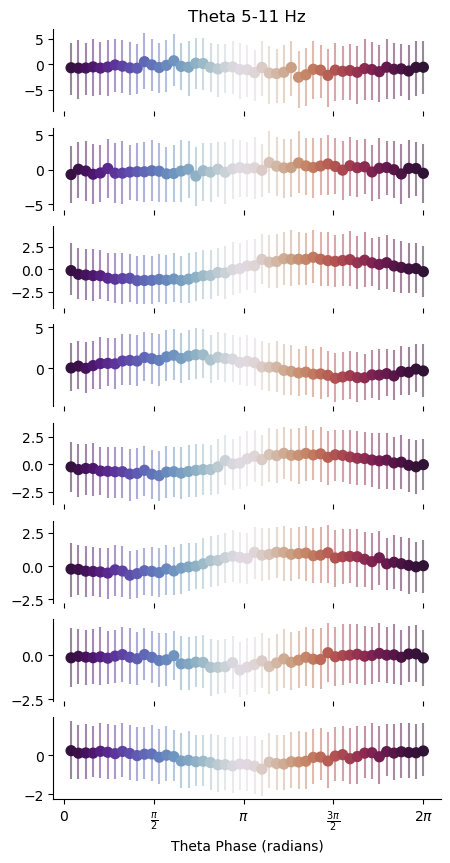

In [123]:
phase_bins = np.linspace(0, 2 * np.pi, 50)

binned_context, bins = analysis.bin_context_by_feature(
    phase_df.phase.values,
    phase_df.index,
    pca=True,
    interpolated=True,
    valid_intervals=all_running_intervals,
    bins=phase_bins,
)

mid = [np.nanmean(b, axis=0) for b in binned_context]
hi = [
    np.nanpercentile(
        b,
        75,
        axis=0,
    )
    for b in binned_context
]
lo = [
    np.nanpercentile(
        b,
        25,
        axis=0,
    )
    for b in binned_context
]
mid = np.array(mid)
lo = np.array(lo)
hi = np.array(hi)
fig, ax = plt.subplots(nrows=min(context_dim, 8), ncols=1, figsize=(5, 10), sharex=True)
c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
for i, a in enumerate(ax):
    a.scatter(bins[1:], mid[:, i], s=50, c=c)
    a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5, color=c)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)

plt.xlabel("Theta Phase (radians)")
plt.xticks(
    np.linspace(0, 2 * np.pi, 5),
    ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
)
ax[0].set_title(theta_key["filter_name"])

### Slow Gamma Band

Text(0.5, 1.0, 'Slow Gamma 25-55 Hz')

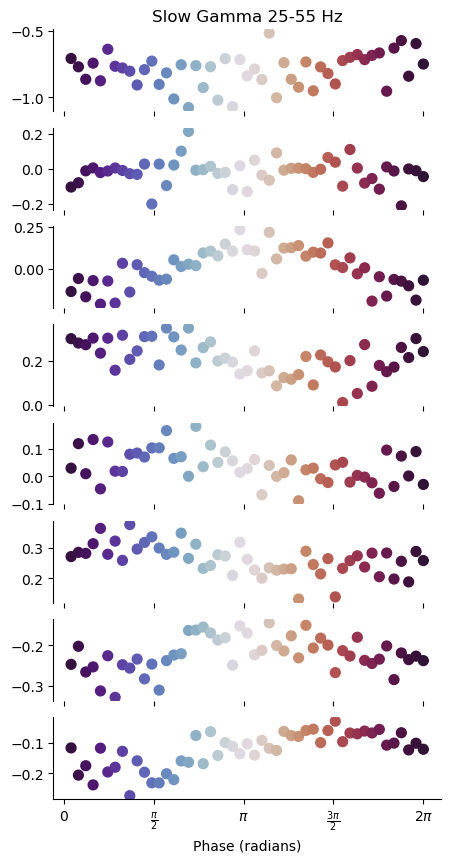

In [124]:
phase_bins = np.linspace(0, 2 * np.pi, 50)

binned_context, bins = analysis.bin_context_by_feature(
    sg_phase_df.phase.values,
    sg_phase_df.index,
    pca=True,
    interpolated=True,
    valid_intervals=all_running_intervals,
    bins=phase_bins,
)

mid = [np.nanmean(b, axis=0) for b in binned_context]
hi = [
    np.nanpercentile(
        b,
        75,
        axis=0,
    )
    for b in binned_context
]
lo = [
    np.nanpercentile(
        b,
        25,
        axis=0,
    )
    for b in binned_context
]
mid = np.array(mid)
lo = np.array(lo)
hi = np.array(hi)
fig, ax = plt.subplots(nrows=min(context_dim, 8), ncols=1, figsize=(5, 10), sharex=True)
c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
for i, a in enumerate(ax):
    a.scatter(bins[1:], mid[:, i], s=50, c=c)
    # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5, color=c)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)

plt.xlabel("Phase (radians)")
plt.xticks(
    np.linspace(0, 2 * np.pi, 5),
    ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
)
ax[0].set_title(slow_gamma_key["filter_name"])

### Fast Gamma Band

Text(0.5, 1.0, 'Fast Gamma 65-100 Hz')

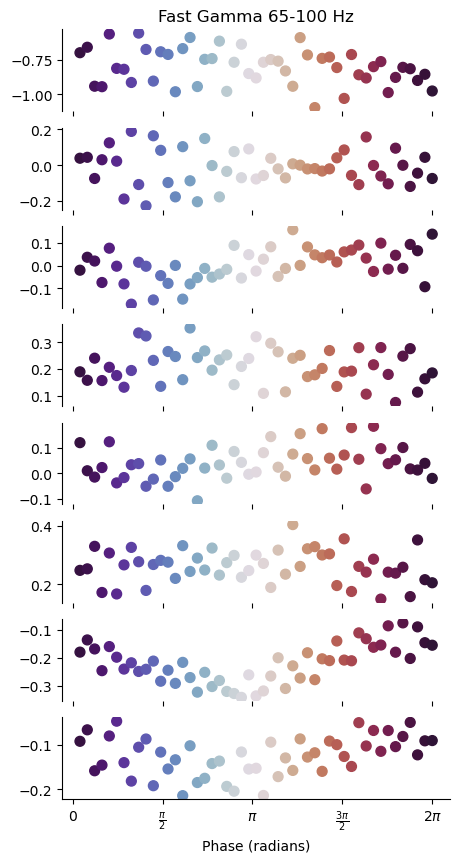

In [125]:
n_plot = 8
hase_bins = np.linspace(0, 2 * np.pi, 20)

binned_context, bins = analysis.bin_context_by_feature(
    fg_phase_df.phase.values,
    fg_phase_df.index,
    pca=True,
    interpolated=True,
    valid_intervals=all_running_intervals,
    bins=phase_bins,
)

mid = [np.nanmean(b, axis=0) for b in binned_context]
hi = [
    np.nanpercentile(
        b,
        75,
        axis=0,
    )
    for b in binned_context
]
lo = [
    np.nanpercentile(
        b,
        25,
        axis=0,
    )
    for b in binned_context
]
mid = np.array(mid)
lo = np.array(lo)
hi = np.array(hi)
fig, ax = plt.subplots(
    nrows=min(context_dim, n_plot), ncols=1, figsize=(5, 10), sharex=True
)
c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
for i, a in enumerate(ax):
    a.scatter(bins[1:], mid[:, i], s=50, c=c)
    # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5, color=c)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)

plt.xlabel("Phase (radians)")
plt.xticks(
    np.linspace(0, 2 * np.pi, 5),
    ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"],
)
ax[0].set_title(fast_gamma_key["filter_name"])

## Theta x Position binning

In [134]:
n_pos = 100
n_theta = 30

left_binned_context, b1, b2 = analysis.bin_context_by_feature_2d(
    pos_df.linear_position.values,
    pos_df.index,
    phase_df.phase.values,
    phase_df.index,
    pca=True,
    interpolated=True,
    valid_intervals=left_running_intervals,
    bins_1=np.linspace(10, 110, n_pos),
    bins_2=np.linspace(0, 2 * np.pi - 0.01, n_theta),
)


right_binned_context, b1, b2 = analysis.bin_context_by_feature_2d(
    pos_df.linear_position.values,
    pos_df.index,
    phase_df.phase.values,
    phase_df.index,
    pca=True,
    interpolated=True,
    valid_intervals=right_running_intervals,
    bins_1=np.linspace(10, 110, n_pos),
    bins_2=np.linspace(0.01, 2 * np.pi - 0.01, n_theta),
)

/tmp/ipykernel_200176/3411208713.py:6: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
/tmp/ipykernel_200176/3411208713.py:15: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)


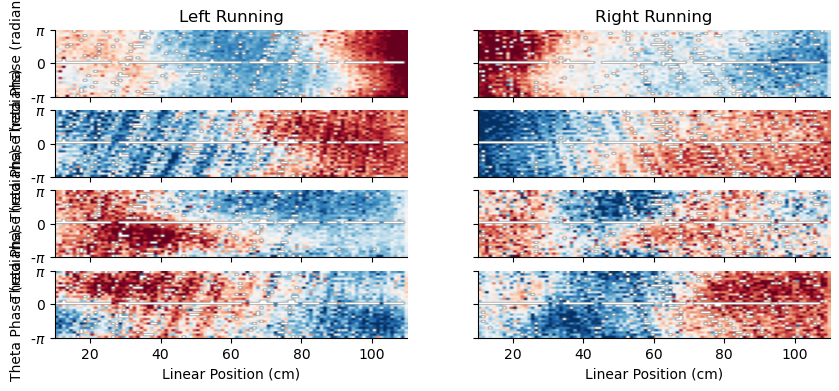

In [ ]:
n_plot = 4

mid_left = np.array(
    [
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in row
        ]
        for row in left_binned_context
    ]
)
mid_right = np.array(
    [
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in row
        ]
        for row in right_binned_context
    ]
)
mid.shape
fig, ax_list = plt.subplots(
    nrows=min(context_dim, n_plot),
    sharex=True,
    sharey=True,
    figsize=(10, n_plot * 1),
    ncols=2,
)


for j, (name, data) in enumerate(zip(["Left", "Right"], [mid_left, mid_right])):
    ax = ax_list[:, j]
    ax[0].set_title(f"{name} Running")
    for i, a in enumerate(ax):
        val = data[:, :, i].T
        val = val - np.nanmean(val)
        val = val / np.nanpercentile(np.abs(val), 97)
        val = np.roll(val, val.shape[0] // 2, axis=0)
        # val = np.concatenate([val,val,], axis=0)
        a.imshow(
            val,
            cmap="RdBu",
            extent=[b1[0], b1[-1], b2[0], b2[-1]],
            aspect="auto",
            clim=(-0.9, 0.9),
        )
        a.spines[
            [
                "top",
                "right",
            ]
        ].set_visible(False)

for a in ax_list[-1]:
    a.spines["bottom"].set_visible(True)
    a.set_xlabel("Linear Position (cm)")
for a in ax_list[:, 0]:
    a.set_ylabel("Theta Phase (radians)")
    a.set_yticks(
        np.linspace(0, 2 * np.pi, 3),
        [r"-$\pi$", "0", r"$\pi$"],
    )

# plt.imshow(mid[:,:,1].T,cmap='RdBu',extent=[b1[0],b1[-1],b2[0],b2[-1]],aspect='auto')
# plt.colorbar()

(40.0, 50.0)

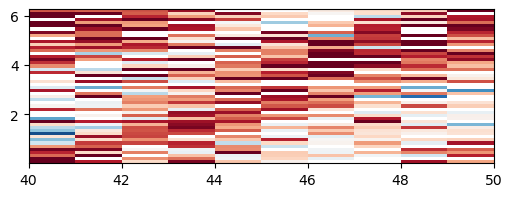

In [ ]:
i = 3
data = mid_left

fig = plt.figure(figsize=(6, 2))
val = data[:, :, i].T
val = val - np.nanmean(val)
val = val / np.nanpercentile(np.abs(val), 97)
val = np.roll(val, val.shape[0] // 2, axis=0)
# val = np.concatenate([val,val,], axis=0)
plt.imshow(
    val,
    cmap="RdBu",
    extent=[b1[0], b1[-1], b2[0], b2[-1]],
    aspect="auto",
    clim=(-0.9, 0.9),
)
plt.xlim(40, 50)

(0.0, 1.0)

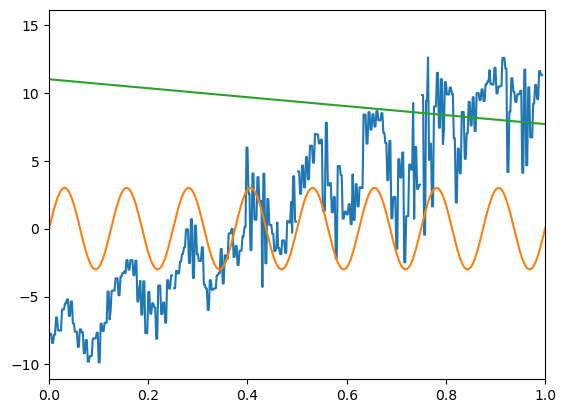

In [ ]:
# simulate left_run

speed = 33  # cm/s
theta_period = 0.125  # seconds

t = np.arange(0, (b1.max() - b1.min()) / speed, 2e-3)
pos = np.linspace(b1.min(), b1.max(), t.size)
pos = np.flip(pos)


theta_phase = (2 * np.pi) * (t % theta_period) / theta_period

pos_ind = np.digitize(pos, b1) - 1
phase_ind = np.digitize(theta_phase, b2) - 1

sim_context = mid_left[pos_ind, phase_ind, :]


# fig, ax = plt.subplots
plt.plot(t, sim_context[:, 0])
plt.plot(t, np.sin(theta_phase) * 3)
plt.plot(t, pos / 10)

plt.xlim(0, 1)
# plt.xlim(2,4)
# plt.xlim(6, 8)

## Sorted Spike response

In [149]:
from spyglass.common import interval_list_contains
from spyglass.common import interval_list_excludes

from src.c3po.analysis.analysis import bootstrap_traces

running = True
neuron_id = 12
spikes = spikes_list[neuron_id]
# spikes = spikes_list[8]
spikes = interval_list_contains(all_running_intervals, spikes)
# spikes = interval_list_excludes(running_intervals,spikes)

window = [-0.5, 1]
# window = [-0.1, 0.1]
# window = [-.02,.02]
response = analysis.alligned_response(spikes, window, pca=True)

yy, rng = bootstrap_traces(response, n_boot=30)

[15:26:54][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead


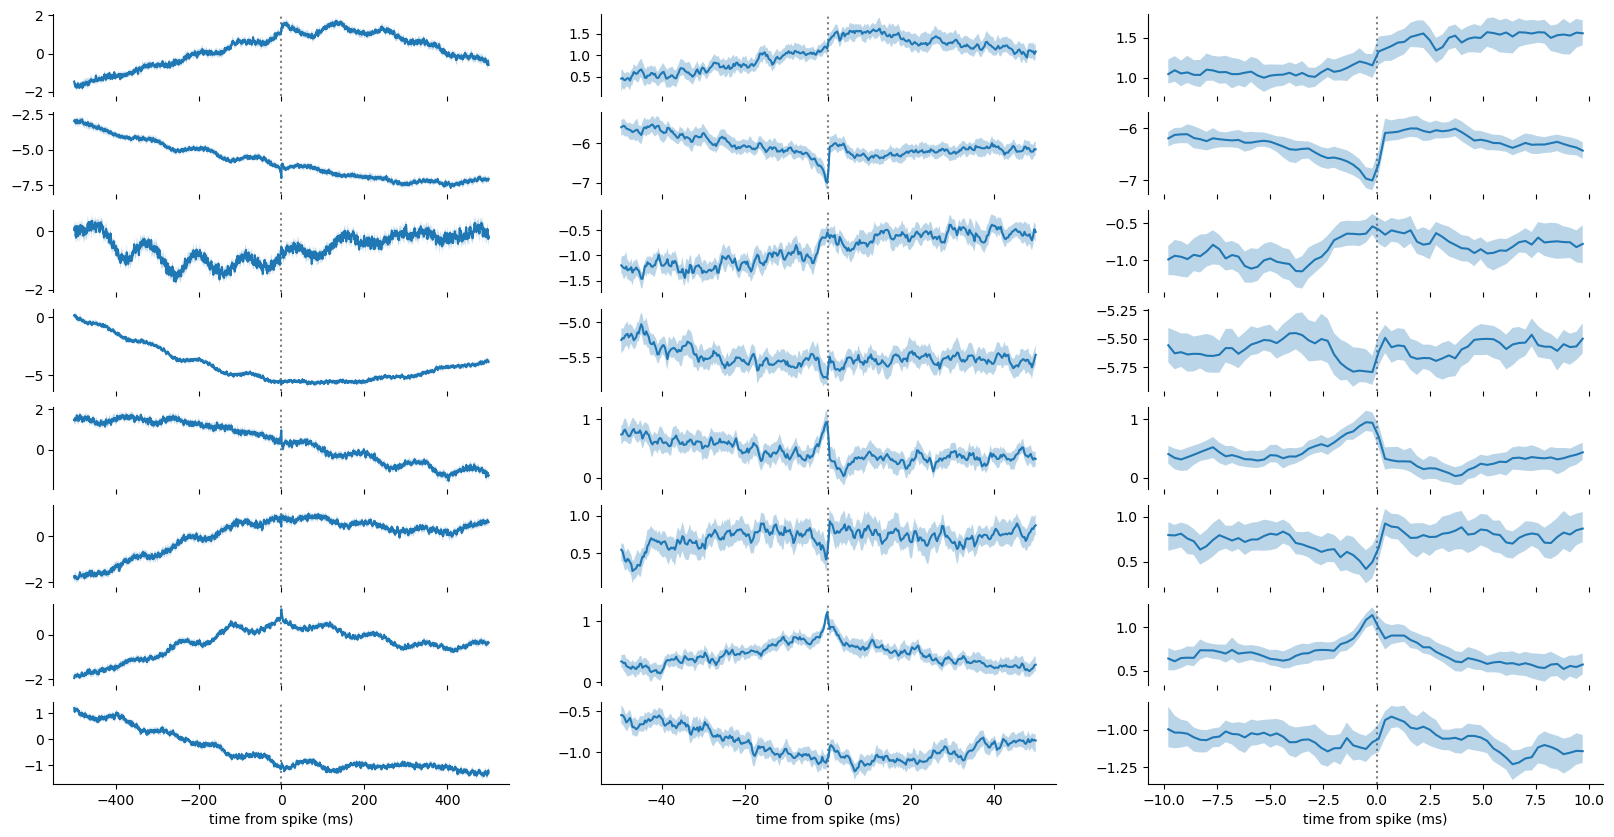

In [150]:
plot_rng_list = [(-500, 500), (-50, 50), (-10, 10)]
fig, ax_list = plt.subplots(
    nrows=min(context_dim, 8), ncols=len(plot_rng_list), sharex="col", figsize=(20, 10)
)


for p, plot_rng in enumerate(plot_rng_list):
    ax = ax_list[:, p]
    c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
    t_plot = np.linspace(window[0], window[-1], response.shape[1]) * 1000
    ind_plot = np.logical_and(
        t_plot >= plot_rng[0],
        t_plot <= plot_rng[1],
    )
    t_plot = t_plot[ind_plot]
    for i, a in enumerate(ax):
        # a.plot(t_plot, np.mean(response[:, :, i], axis=0))
        a.plot(t_plot, yy[ind_plot, i])
        a.fill_between(t_plot, rng[0][ind_plot, i], rng[1][ind_plot, i], alpha=0.3)
        a.axvline(0, ls=":", c="grey", zorder=-1)
        # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
        a.spines[["top", "right", "bottom"]].set_visible(False)
    ax[-1].spines["bottom"].set_visible(True)
    ax[-1].set_xlabel("time from spike (ms)")

# fig.savefig(
#     f"{plot_folder}hpc_spike_response_{'running' if running else 'stationary'}_"
#     + f"neuron{neuron_id}_{int(window[0]*1000)}-{int(window[1]*1000)}ms.pdf",
# )

In [77]:
x = 100 or 5
print(x)

100

## Ripple Response

In [182]:
mark_id = "start_time"
ripple_intervals = ripple_df[["start_time", "end_time"]].values

mark_intervals = [r for r in ripple_intervals if r[1] - r[0] > 0.1]
mark_intervals = np.array(mark_intervals)

marks = mark_intervals[:, 0]

# marks = ripple_df[mark_id].values
# marks = ripple_df.end_time.values

window = [-0.5, 1]
# window = [-0.1, 0.1]
# window = [-0.02, 0.02]
# window = [0,.05]
response = analysis.alligned_response(marks, window, pca=True)

yy, rng = bootstrap_traces(response, n_boot=30)

Text(0.5, 0.98, 'HPC Ripple start time')

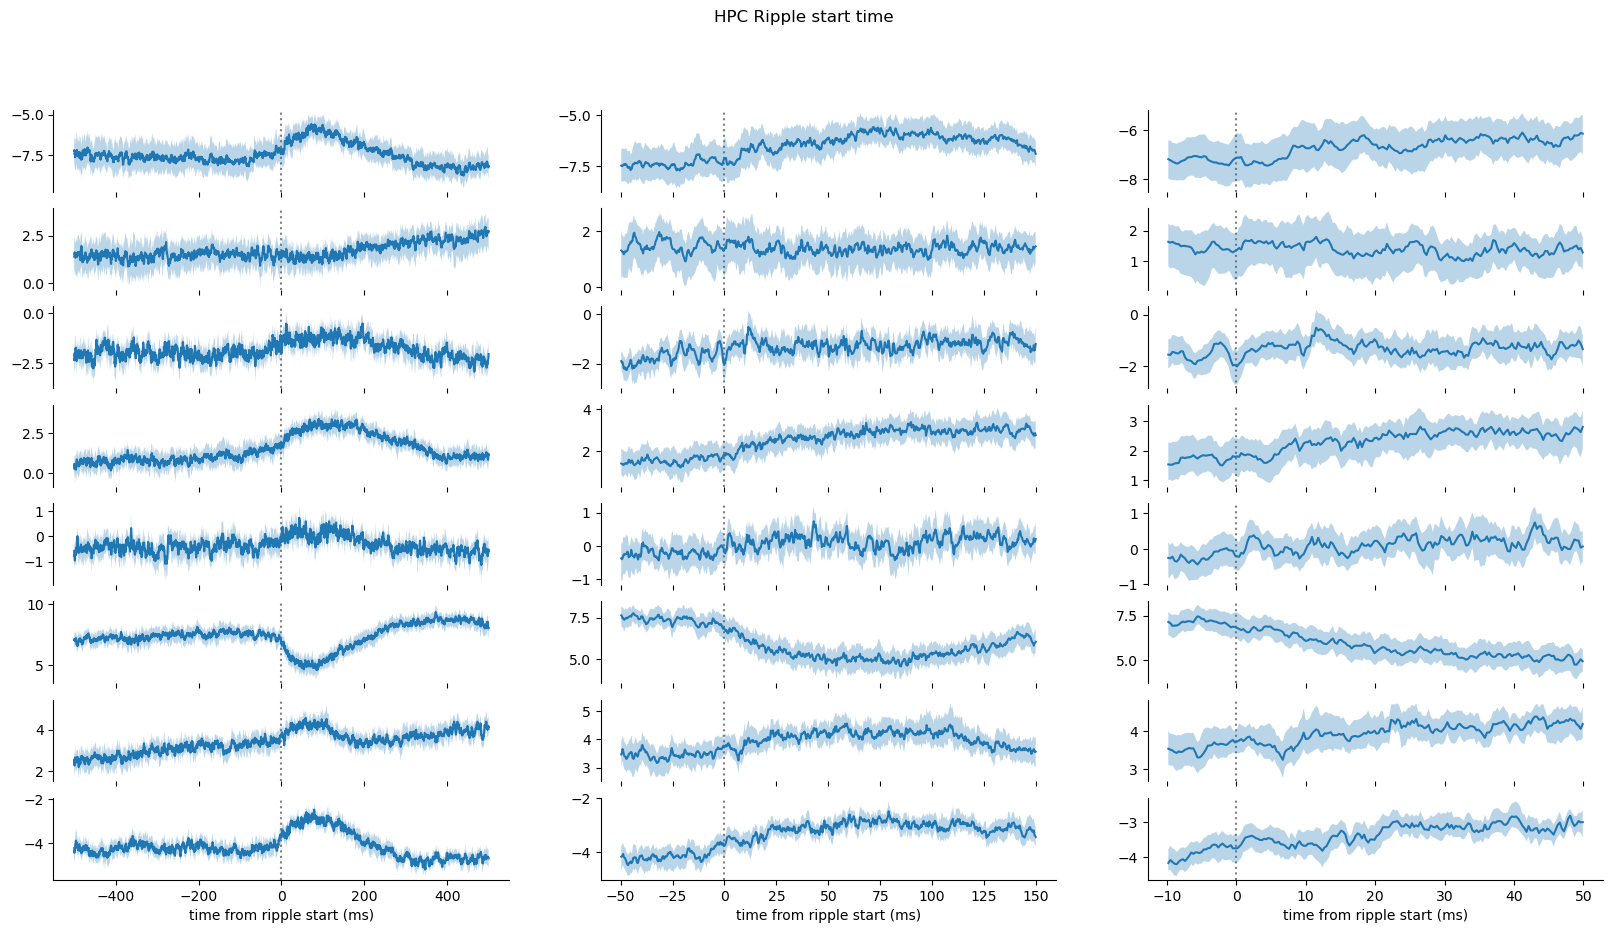

In [183]:
plot_rng_list = [(-500, 500), (-50, 150), (-10, 50)]
fig, ax_list = plt.subplots(
    nrows=min(context_dim, 8), ncols=len(plot_rng_list), sharex="col", figsize=(20, 10)
)


for p, plot_rng in enumerate(plot_rng_list):
    ax = ax_list[:, p]
    c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
    t_plot = np.linspace(window[0], window[-1], response.shape[1]) * 1000
    ind_plot = np.logical_and(
        t_plot >= plot_rng[0],
        t_plot <= plot_rng[1],
    )
    t_plot = t_plot[ind_plot]
    for i, a in enumerate(ax):
        # a.plot(t_plot, np.mean(response[:, :, i], axis=0))
        a.plot(t_plot, yy[ind_plot, i])
        a.fill_between(t_plot, rng[0][ind_plot, i], rng[1][ind_plot, i], alpha=0.3)
        a.axvline(0, ls=":", c="grey", zorder=-1)
        # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
        a.spines[["top", "right", "bottom"]].set_visible(False)
    ax[-1].spines["bottom"].set_visible(True)
    ax[-1].set_xlabel("time from ripple start (ms)")

fig.suptitle(f"HPC Ripple {mark_id.replace('_',' ')}")

In [155]:
ripple_intervals = ripple_df[["start_time", "end_time"]].values

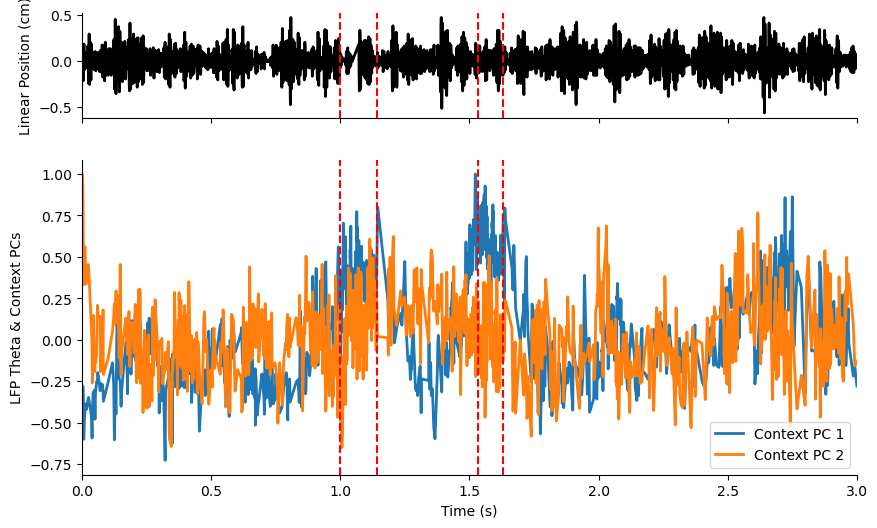

In [ ]:
i = 4
t_rng = -0.1, 0.3


i = 43
t_rng = -1, 2


pc_inds = np.array(
    [
        0,
        1,
    ]
)
# t_rng = 3,4

fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    height_ratios=[1, 3],
    figsize=(10, 6),
)

interval = [i_ for i_ in ripple_intervals if i_[1] - i_[0] > 0.1]
interval = interval[i]
st = interval[0] + t_rng[0]
en = interval[0] + t_rng[1]

t_ripple = ripple_band_obj.timestamps
ind_ripple = np.logical_and(
    t_ripple >= st,
    t_ripple <= en,
)
ax[0].plot(
    t_ripple[ind_ripple] - st,
    ripple_band_obj.data[ind_ripple][:, ref_ind] / 100,
    c="k",
    lw=2,
    zorder=-10,
    label="LFP Theta Band",
)

ind_context = np.logical_and(
    analysis.t_interp >= st,
    analysis.t_interp <= en,
)
c_plot = analysis.c_pca_interp[ind_context][:, pc_inds]
if len(c_plot.shape) == 1:
    c_plot = c_plot[:, None]

c_plot = gaussian_filter1d(c_plot, 1, axis=0, mode="nearest")
c_plot = c_plot - np.mean(c_plot, axis=0)
c_plot = c_plot / (np.max(np.abs(c_plot), axis=0))
for j in range(c_plot.shape[1]):
    plt.plot(
        analysis.t_interp[ind_context] - st,
        c_plot[:, j],
        zorder=-1,
        label=f"Context PC {j+1}",
        lw=2,
    )

ax[1].legend(loc="lower right")
for a in ax:
    a.spines[["top", "right"]].set_visible(False)

ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("Linear Position (cm)")
ax[1].set_ylabel("LFP Theta & Context PCs")
plt.xlim(0, t_rng[1] - t_rng[0])

# for t_ in interval:
#     ax[1].axvline(interval[0] - st, color="red", ls="--")

for ripple in ripple_intervals:
    # if ripple[0] > st and ripple[1] < en:
    #     for a in ax:
    #         a.axvline(ripple[0] - st, color="r", ls="--")
    #         a.axvline(ripple[1] - st, color="r", ls="--")
    for r in np.ravel(ripple):
        if r >= st and r <= en:
            for a in ax:
                a.axvline(r - st, color="r", ls="--")

# ax[0].fill_betweenx(
#     interval[0] - st,
#     interval[1] - st,
#     color="red",
#     alpha=0.3,
# )

In [166]:
interval[0]

1663021525.3365562

## Behavior-alligned responses

### Licks

In [227]:
dio = "poke"
marks = behavior_evenets[dio]
marks = marks[np.logical_and(marks > analysis.t[0], marks < analysis.t[-1])]
response = analysis.alligned_response(marks, window, pca=True)

yy, rng = bootstrap_traces(response, n_boot=100)

Text(0.5, 0.98, 'HPC poke')

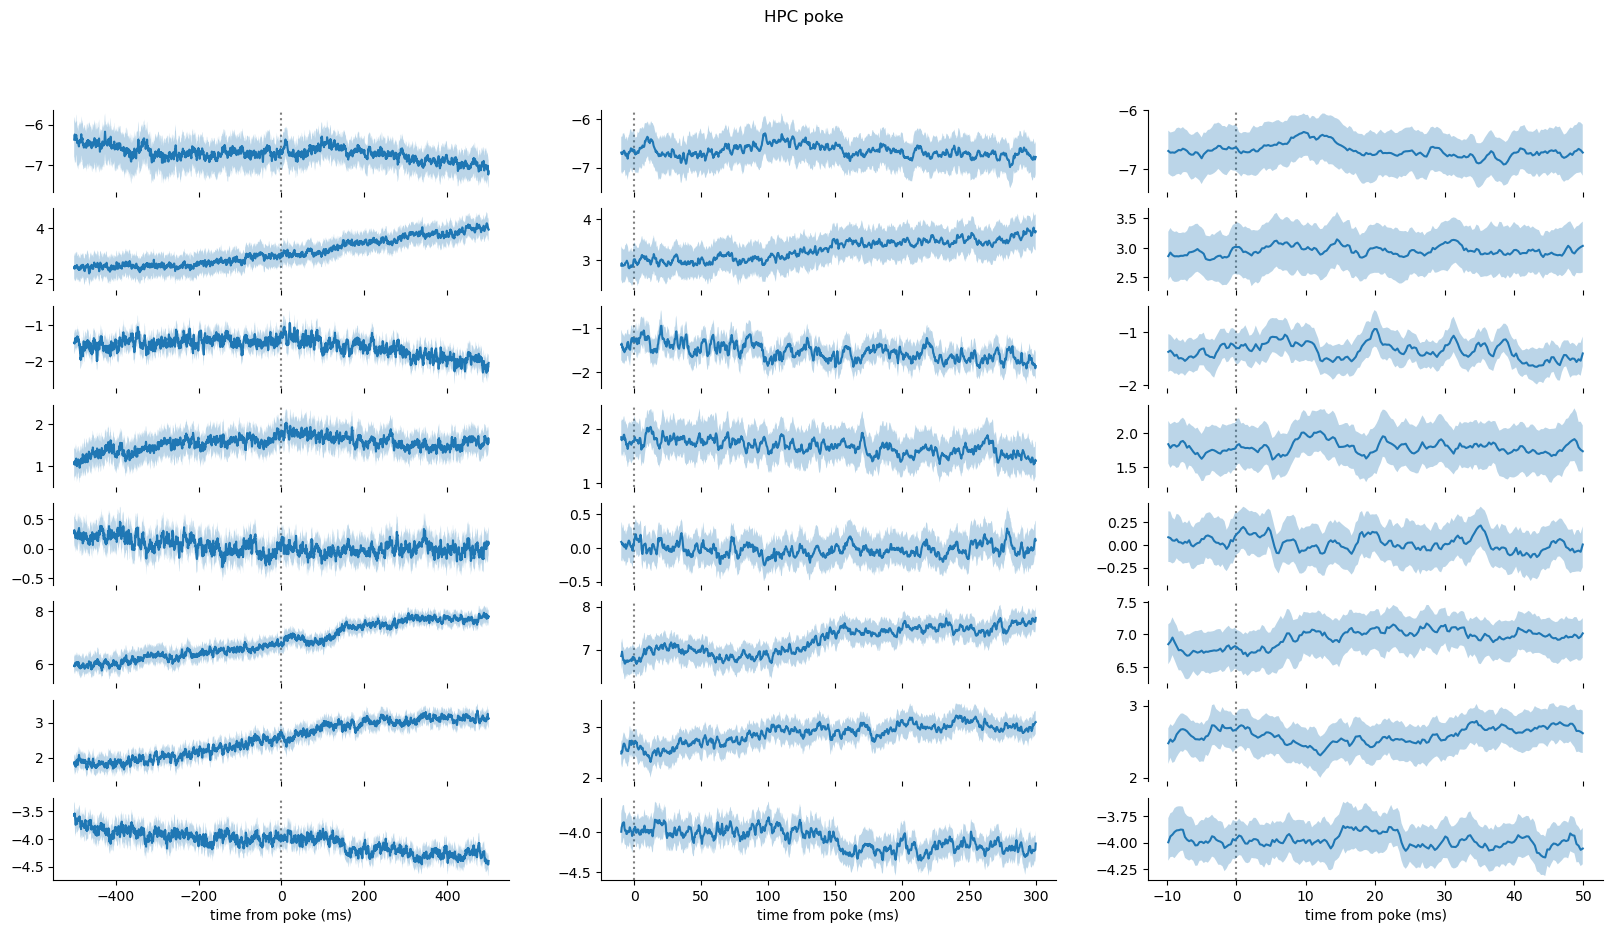

In [228]:
plot_rng_list = [(-500, 500), (-10, 300), (-10, 50)]
fig, ax_list = plt.subplots(
    nrows=min(context_dim, 8), ncols=len(plot_rng_list), sharex="col", figsize=(20, 10)
)


for p, plot_rng in enumerate(plot_rng_list):
    ax = ax_list[:, p]
    c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
    t_plot = np.linspace(window[0], window[-1], response.shape[1]) * 1000
    ind_plot = np.logical_and(
        t_plot >= plot_rng[0],
        t_plot <= plot_rng[1],
    )
    t_plot = t_plot[ind_plot]
    for i, a in enumerate(ax):
        # a.plot(t_plot, np.mean(response[:, :, i], axis=0))
        a.plot(t_plot, yy[ind_plot, i])
        a.fill_between(t_plot, rng[0][ind_plot, i], rng[1][ind_plot, i], alpha=0.3)
        a.axvline(0, ls=":", c="grey", zorder=-1)
        # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
        a.spines[["top", "right", "bottom"]].set_visible(False)
    ax[-1].spines["bottom"].set_visible(True)
    ax[-1].set_xlabel("time from poke (ms)")

fig.suptitle(f"HPC {dio}")

### Rewards

In [235]:
dio = "reward"
marks = behavior_evenets[dio]
marks = marks[np.logical_and(marks > analysis.t[0], marks < analysis.t[-1])]
response = analysis.alligned_response(marks, window, pca=True)

yy, rng = bootstrap_traces(response, n_boot=100)

Text(0.5, 1.0, 'HPC reward event')

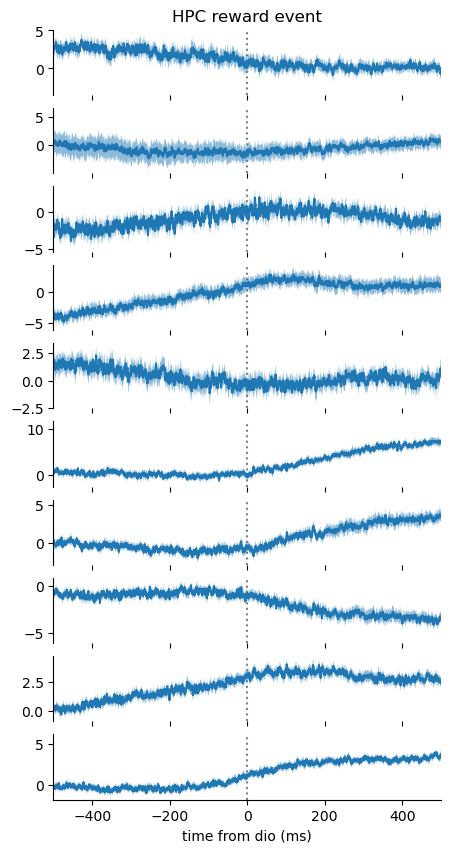

In [236]:
fig, ax = plt.subplots(nrows=min(context_dim, 10), sharex=True, figsize=(5, 10))

c = [plt.cm.twilight_shifted(phase / (2 * np.pi)) for phase in bins[1:]]
t_plot = np.linspace(window[0], window[-1], response.shape[1]) * 1000
for i, a in enumerate(ax):
    # a.plot(t_plot, np.mean(response[:, :, i], axis=0))
    a.plot(t_plot, yy[:, i])
    a.fill_between(
        t_plot,
        rng[0][:, i],
        rng[1][:, i],
        alpha=0.5,
        # facecolor=c[0],
    )

    a.axvline(0, ls=":", c="grey", zorder=-1)
    # a.vlines(bins[1:], lo[:, i], hi[:, i], alpha=0.5)
    a.spines[["top", "right", "bottom"]].set_visible(False)
ax[-1].spines["bottom"].set_visible(True)
plt.xlim(-500, 500)
plt.xlabel("time from dio (ms)")
ax[0].set_title(f"HPC {dio} event")

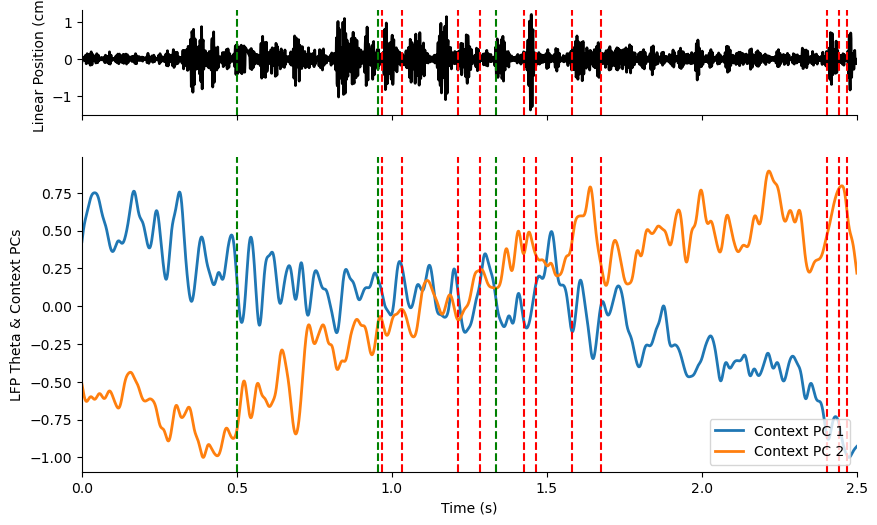

In [ ]:
i = 8
t_rng = -0.5, 2
smooth = 31


pc_inds = np.array(
    [
        0,
        1,
    ]
)
# t_rng = 3,4

fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    height_ratios=[1, 3],
    figsize=(10, 6),
)


st = marks[i] + t_rng[0]
en = marks[i] + t_rng[1]

t_ripple = ripple_band_obj.timestamps
ind_ripple = np.logical_and(
    t_ripple >= st,
    t_ripple <= en,
)
ax[0].plot(
    t_ripple[ind_ripple] - st,
    ripple_band_obj.data[ind_ripple][:, ref_ind] / 100,
    c="k",
    lw=2,
    zorder=-10,
    label="LFP Theta Band",
)

ind_context = np.logical_and(
    analysis.t_interp >= st,
    analysis.t_interp <= en,
)
c_plot = analysis.c_pca_interp[ind_context][:, pc_inds]
if len(c_plot.shape) == 1:
    c_plot = c_plot[:, None]

c_plot = gaussian_filter1d(c_plot, smooth, axis=0, mode="nearest")
c_plot = c_plot - np.mean(c_plot, axis=0)
c_plot = c_plot / (np.max(np.abs(c_plot), axis=0))
for j in range(c_plot.shape[1]):
    plt.plot(
        analysis.t_interp[ind_context] - st,
        c_plot[:, j],
        zorder=-1,
        label=f"Context PC {j+1}",
        lw=2,
    )

ax[1].legend(loc="lower right")
for a in ax:
    a.spines[["top", "right"]].set_visible(False)

ax[1].set_xlabel("Time (s)")
ax[0].set_ylabel("Linear Position (cm)")
ax[1].set_ylabel("LFP Theta & Context PCs")
plt.xlim(0, t_rng[1] - t_rng[0])

# for t_ in interval:
#     ax[1].axvline(interval[0] - st, color="red", ls="--")

for ripple in ripple_intervals:
    # if ripple[0] > st and ripple[1] < en:
    #     for a in ax:
    #         a.axvline(ripple[0] - st, color="r", ls="--")
    #         a.axvline(ripple[1] - st, color="r", ls="--")
    for r in np.ravel(ripple):
        if r >= st and r <= en:
            for a in ax:
                a.axvline(r - st, color="r", ls="--")

for poke in behavior_evenets["poke"]:
    if poke >= st and poke <= en:
        for a in ax:
            a.axvline(poke - st, color="g", ls="--")

# ax[0].fill_betweenx(
#     interval[0] - st,
#     interval[1] - st,
#     color="red",
#     alpha=0.3,
# )